In [35]:
from __future__ import absolute_import, division, print_function
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm       # a nice pretty percentage bar for tasks. Thanks to viewer Daniel BA1/4hler for this suggestion

from termcolor import colored
import tensorflow as tf
import os                   # work with directories
import numpy as np          # dealing with arrays
import matplotlib.pyplot as plt
import time

tfe = tf.contrib.eager
import pickle as pk
import random
import sys

from tensorflow.python.client import device_lib
from tensorflow.python.eager import tape


config = tf.ConfigProto()
config.gpu_options.allow_growth = True
layers = tf.keras.layers
tf.enable_eager_execution(config=config)
tf.executing_eagerly()
print(tf.__version__)


HOME_DIR = '/home/moe/PycharmProjects/clean_code/'
MAIN_dir = '/home/moe/PycharmProjects/clean_code/Cleaned_code/'
elevator_path = '/home/moe/Desktop/bambo_Logs/Data/elevator_fulldata/process/'
excel_file = '/home/moe/Desktop/bambo_Logs/Data/weight_log_summary_602020.xlsx'
dataset_path = '/home/moe/Desktop/bambo_Logs/Data/my_dataset/'
logs_path = MAIN_dir + 'Stereo_volume_data/lowlightlogs.npy'

def print_progress(cnt, total_items,time_):
    percent_complete = float(cnt) / total_items
    sec = int(time_ % 60)
    mint = int(time_/60) % 60
    hr = int(time_/3600) % 60
    msg = "\r Time_lapsed (hr:mm:ss) --> {0:02d}:{1:02d}:{2:02d} , Progress:{3:.1%}, completed {4:d} " \
          "out of {5:d} items ".format(hr, mint, sec, percent_complete, cnt, total_items)
    sys.stdout.write(msg)
    sys.stdout.flush()

In [36]:

pickle_in_train = open(MAIN_dir + 'data_files/' + "lighting_and_full_data.pickle", "rb")
volume_data = pk.load(pickle_in_train)
pickle_in_train.close()
Log_name = volume_data["Log_name"]
ground_truth = volume_data["Weight"]
Speed = volume_data["Speed"]
Volume = volume_data["Volume"]
Time_ = volume_data["Time"]
light = volume_data["lighting"]
length_ = volume_data["Length"]
Volume_Speed = volume_data["Volume_Speed"]

vol_logs = np.load(logs_path)

In [37]:
pickle_in_test = open(MAIN_dir + 'data_files/' + "test_full_data.pickle", "rb")
test_data = pk.load(pickle_in_test)
pickle_in_test.close()
Log_name_t = test_data["Log_name"]
Volume_t = test_data["Volume"]
Speed_t = test_data["Speed"]
ground_truth_t = test_data["Weight"]

pickle_in_val = open(MAIN_dir + 'data_files/' + "validation_full_data.pickle", "rb")
val_data = pk.load(pickle_in_val)
pickle_in_val.close()
Log_name_d = val_data["Log_name"]
Volume_d = val_data["Volume"]
Speed_d = val_data["Speed"]
ground_truth_d = val_data["Weight"]

pickle_in_train = open(MAIN_dir + 'data_files/' + "train_full_data.pickle", "rb")
train_data = pk.load(pickle_in_train)
pickle_in_train.close()
Log_name_tr = train_data["Log_name"]
Volume_tr = train_data["Volume"]
Speed_tr = train_data["Speed"]
ground_truth_tr = train_data["Weight"]

In [13]:
print(len(Log_name_t), len(Volume_t), len(Speed_d))

48 48 48


In [38]:
def model_neg(vol):
    beta = 0.24774203504591996
    vol_b = tf.nn.relu(vol - beta)
    w1 = tf.constant([-0.28591041,  0.06418912,  1.13736639])
    b1 = tf.constant([-0.08105918,  0.11260413, -0.04404414])
    w2 = tf.constant([-0.21627961, -0.05380324, 0.0326613 ])
    w2_1 = tf.reshape(w2, [3, 1])
    b2 = tf.constant([-0.13866211])
    L1 = tf.add(tf.math.scalar_mul(vol_b, w1), b1) 
    L1_1 = tf.nn.tanh(L1)
    L1_1 = tf.reshape(L1_1, [1, 3])
    L2 = tf.add(tf.matmul(L1_1, w2_1), b2)
    L2_1 = L2 * vol_b
    return L2_1


def model_pos(vol):
    beta = 2.759320676099754
    vol_b = tf.nn.relu(vol - beta)
    w1 = tf.constant([1.51248678, 0.05577656, 1.13650198])
    b1 = tf.constant([0.69135934, 0.22673389, 0.05709011])
    w2 = [[-0.14444944], [-1.25086896], [-0.19815545]]
    b2 = tf.constant([-1.24339893])
    L1 = tf.add(tf.math.scalar_mul(vol_b, w1), b1) 
    L1_1 = tf.nn.tanh(L1)
    L1_1 = tf.reshape(L1_1, [1, 3])
    L2 = tf.add(tf.matmul(L1_1, w2), b2)
    L21 = tf.exp(L2)
    L2_1 = L21 * vol_b
    return L2_1


In [47]:
mass_prd = []
instant_mass = []
sum_x = 0
start = time.time()
items = len(Log_name_d)
for i, log in (enumerate(Log_name_d)):
    for j, v in enumerate(Volume_d[i]):
        x = (model_neg(np.float(v)) * Speed_d[i][j])
        instant_mass.append(x)
        sum_x += x
    mass_prd.append([np.squeeze(sum_x.numpy()), np.array(instant_mass[0:len(instant_mass)]), Log_name_d[i]])
    instant_mass.clear()
    sum_x = 0
    end = time.time() - start
    print_progress(i+1, items, end)
np.save(MAIN_dir+'Signals/instant_mass_prd_validate_named.npy', mass_prd)

 Time_lapsed (hr:mm:ss) --> 00:00:00 , Progress:2.1%, completed 1 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:00 , Progress:4.2%, completed 2 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:00 , Progress:6.2%, completed 3 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:01 , Progress:8.3%, completed 4 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:01 , Progress:10.4%, completed 5 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:01 , Progress:12.5%, completed 6 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:02 , Progress:14.6%, completed 7 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:02 , Progress:16.7%, completed 8 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:02 , Progress:18.8%, completed 9 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:03 , Progress:20.8%, completed 10 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:03 , Progress:22.9%, completed 11 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:03 , Progress:25.0%, completed 12 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:03 , Progress:27.1%, completed 13 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:04 , Progress:29.2%, completed 14 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:04 , Progress:31.2%, completed 15 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:04 , Progress:33.3%, completed 16 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:04 , Progress:35.4%, completed 17 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:05 , Progress:37.5%, completed 18 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:05 , Progress:39.6%, completed 19 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:05 , Progress:41.7%, completed 20 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:06 , Progress:43.8%, completed 21 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:06 , Progress:45.8%, completed 22 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:06 , Progress:47.9%, completed 23 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:06 , Progress:50.0%, completed 24 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:06 , Progress:52.1%, completed 25 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:07 , Progress:54.2%, completed 26 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:07 , Progress:56.2%, completed 27 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:08 , Progress:58.3%, completed 28 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:08 , Progress:60.4%, completed 29 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:08 , Progress:62.5%, completed 30 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:08 , Progress:64.6%, completed 31 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:09 , Progress:66.7%, completed 32 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:10 , Progress:68.8%, completed 33 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:11 , Progress:70.8%, completed 34 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:11 , Progress:72.9%, completed 35 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:11 , Progress:75.0%, completed 36 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:12 , Progress:77.1%, completed 37 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:12 , Progress:79.2%, completed 38 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:12 , Progress:81.2%, completed 39 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:12 , Progress:83.3%, completed 40 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:12 , Progress:85.4%, completed 41 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:13 , Progress:87.5%, completed 42 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:13 , Progress:89.6%, completed 43 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:13 , Progress:91.7%, completed 44 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:13 , Progress:93.8%, completed 45 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:14 , Progress:95.8%, completed 46 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:14 , Progress:97.9%, completed 47 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:14 , Progress:100.0%, completed 48 out of 48 items 

In [46]:
mass_prd = []
instant_mass = []
sum_x = 0
start = time.time()
items = len(Log_name_t)
for i, log in (enumerate(Log_name_t)):
    for j, v in enumerate(Volume_t[i]):
        x = (model_neg(np.float(v)) * Speed_t[i][j])
        instant_mass.append(x)
        sum_x += x
    mass_prd.append([np.squeeze(sum_x.numpy()), np.array(instant_mass[0:len(instant_mass)]), Log_name_t[i]])
    instant_mass.clear()
    sum_x = 0
    end = time.time() - start
    print_progress(i+1, items, end)
np.save(MAIN_dir+'Signals/instant_mass_prd_test_named.npy', mass_prd)

 Time_lapsed (hr:mm:ss) --> 00:00:00 , Progress:2.1%, completed 1 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:00 , Progress:4.2%, completed 2 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:00 , Progress:6.2%, completed 3 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:00 , Progress:8.3%, completed 4 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:01 , Progress:10.4%, completed 5 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:01 , Progress:12.5%, completed 6 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:02 , Progress:14.6%, completed 7 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:02 , Progress:16.7%, completed 8 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:02 , Progress:18.8%, completed 9 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:02 , Progress:20.8%, completed 10 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:03 , Progress:22.9%, completed 11 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:03 , Progress:25.0%, completed 12 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:04 , Progress:27.1%, completed 13 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:04 , Progress:29.2%, completed 14 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:04 , Progress:31.2%, completed 15 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:05 , Progress:33.3%, completed 16 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:05 , Progress:35.4%, completed 17 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:05 , Progress:37.5%, completed 18 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:05 , Progress:39.6%, completed 19 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:05 , Progress:41.7%, completed 20 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:05 , Progress:43.8%, completed 21 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:06 , Progress:45.8%, completed 22 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:06 , Progress:47.9%, completed 23 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:06 , Progress:50.0%, completed 24 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:06 , Progress:52.1%, completed 25 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:07 , Progress:54.2%, completed 26 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:07 , Progress:56.2%, completed 27 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:07 , Progress:58.3%, completed 28 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:07 , Progress:60.4%, completed 29 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:08 , Progress:62.5%, completed 30 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:08 , Progress:64.6%, completed 31 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:08 , Progress:66.7%, completed 32 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:08 , Progress:68.8%, completed 33 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:08 , Progress:70.8%, completed 34 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:09 , Progress:72.9%, completed 35 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:09 , Progress:75.0%, completed 36 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:09 , Progress:77.1%, completed 37 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:10 , Progress:79.2%, completed 38 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:10 , Progress:81.2%, completed 39 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:10 , Progress:83.3%, completed 40 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:10 , Progress:85.4%, completed 41 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:10 , Progress:87.5%, completed 42 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:10 , Progress:89.6%, completed 43 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:10 , Progress:91.7%, completed 44 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:11 , Progress:93.8%, completed 45 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:11 , Progress:95.8%, completed 46 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:11 , Progress:97.9%, completed 47 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:11 , Progress:100.0%, completed 48 out of 48 items 

In [45]:
mass_prd = []
instant_mass = []
sum_x = 0
start = time.time()
items = len(Log_name_tr)
for i, log in (enumerate(Log_name_tr)):
    for j, v in enumerate(Volume_tr[i]):
        x = (model_neg(np.float(v)) * Speed_tr[i][j])
        instant_mass.append(x)
        sum_x += x
    mass_prd.append([np.squeeze(sum_x.numpy()), np.array(instant_mass[0:len(instant_mass)]), Log_name_tr[i]])
    instant_mass.clear()
    sum_x = 0
    end = time.time() - start
    print_progress(i+1, items, end)
np.save(MAIN_dir+'Signals/instant_mass_prd_train_named.npy', mass_prd)

 Time_lapsed (hr:mm:ss) --> 00:00:00 , Progress:0.7%, completed 1 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:00 , Progress:1.4%, completed 2 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:01 , Progress:2.1%, completed 3 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:01 , Progress:2.8%, completed 4 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:01 , Progress:3.5%, completed 5 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:02 , Progress:4.2%, completed 6 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:02 , Progress:4.9%, completed 7 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:02 , Progress:5.6%, completed 8 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:02 , Progress:6.3%, completed 9 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:03 , Progress:7.0%, completed 10 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:03 , Progress:7.7%, completed 11 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:03 , Progress:8.4%, completed 12 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:03 , Progress:9.1%, completed 13 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:03 , Progress:9.8%, completed 14 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:03 , Progress:10.5%, completed 15 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:04 , Progress:11.2%, completed 16 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:04 , Progress:11.9%, completed 17 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:04 , Progress:12.6%, completed 18 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:04 , Progress:13.3%, completed 19 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:05 , Progress:14.0%, completed 20 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:05 , Progress:14.7%, completed 21 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:05 , Progress:15.4%, completed 22 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:05 , Progress:16.1%, completed 23 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:06 , Progress:16.8%, completed 24 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:06 , Progress:17.5%, completed 25 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:06 , Progress:18.2%, completed 26 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:07 , Progress:18.9%, completed 27 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:07 , Progress:19.6%, completed 28 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:07 , Progress:20.3%, completed 29 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:07 , Progress:21.0%, completed 30 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:08 , Progress:21.7%, completed 31 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:08 , Progress:22.4%, completed 32 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:08 , Progress:23.1%, completed 33 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:08 , Progress:23.8%, completed 34 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:09 , Progress:24.5%, completed 35 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:09 , Progress:25.2%, completed 36 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:09 , Progress:25.9%, completed 37 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:10 , Progress:26.6%, completed 38 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:10 , Progress:27.3%, completed 39 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:10 , Progress:28.0%, completed 40 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:10 , Progress:28.7%, completed 41 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:11 , Progress:29.4%, completed 42 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:11 , Progress:30.1%, completed 43 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:11 , Progress:30.8%, completed 44 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:11 , Progress:31.5%, completed 45 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:11 , Progress:32.2%, completed 46 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:12 , Progress:32.9%, completed 47 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:12 , Progress:33.6%, completed 48 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:12 , Progress:34.3%, completed 49 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:13 , Progress:35.0%, completed 50 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:13 , Progress:35.7%, completed 51 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:13 , Progress:36.4%, completed 52 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:13 , Progress:37.1%, completed 53 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:14 , Progress:37.8%, completed 54 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:14 , Progress:38.5%, completed 55 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:14 , Progress:39.2%, completed 56 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:16 , Progress:39.9%, completed 57 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:17 , Progress:40.6%, completed 58 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:17 , Progress:41.3%, completed 59 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:17 , Progress:42.0%, completed 60 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:17 , Progress:42.7%, completed 61 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:17 , Progress:43.4%, completed 62 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:18 , Progress:44.1%, completed 63 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:18 , Progress:44.8%, completed 64 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:18 , Progress:45.5%, completed 65 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:19 , Progress:46.2%, completed 66 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:19 , Progress:46.9%, completed 67 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:19 , Progress:47.6%, completed 68 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:19 , Progress:48.3%, completed 69 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:20 , Progress:49.0%, completed 70 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:20 , Progress:49.7%, completed 71 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:20 , Progress:50.3%, completed 72 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:21 , Progress:51.0%, completed 73 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:21 , Progress:51.7%, completed 74 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:21 , Progress:52.4%, completed 75 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:21 , Progress:53.1%, completed 76 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:21 , Progress:53.8%, completed 77 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:22 , Progress:54.5%, completed 78 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:22 , Progress:55.2%, completed 79 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:22 , Progress:55.9%, completed 80 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:22 , Progress:56.6%, completed 81 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:23 , Progress:57.3%, completed 82 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:23 , Progress:58.0%, completed 83 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:23 , Progress:58.7%, completed 84 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:23 , Progress:59.4%, completed 85 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:24 , Progress:60.1%, completed 86 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:24 , Progress:60.8%, completed 87 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:24 , Progress:61.5%, completed 88 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:24 , Progress:62.2%, completed 89 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:24 , Progress:62.9%, completed 90 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:25 , Progress:63.6%, completed 91 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:25 , Progress:64.3%, completed 92 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:25 , Progress:65.0%, completed 93 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:26 , Progress:65.7%, completed 94 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:26 , Progress:66.4%, completed 95 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:26 , Progress:67.1%, completed 96 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:26 , Progress:67.8%, completed 97 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:26 , Progress:68.5%, completed 98 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:27 , Progress:69.2%, completed 99 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:27 , Progress:69.9%, completed 100 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:28 , Progress:70.6%, completed 101 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:28 , Progress:71.3%, completed 102 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:28 , Progress:72.0%, completed 103 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:29 , Progress:72.7%, completed 104 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:29 , Progress:73.4%, completed 105 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:29 , Progress:74.1%, completed 106 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:29 , Progress:74.8%, completed 107 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:30 , Progress:75.5%, completed 108 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:30 , Progress:76.2%, completed 109 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:30 , Progress:76.9%, completed 110 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:30 , Progress:77.6%, completed 111 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:30 , Progress:78.3%, completed 112 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:31 , Progress:79.0%, completed 113 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:31 , Progress:79.7%, completed 114 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:31 , Progress:80.4%, completed 115 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:32 , Progress:81.1%, completed 116 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:32 , Progress:81.8%, completed 117 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:32 , Progress:82.5%, completed 118 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:32 , Progress:83.2%, completed 119 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:32 , Progress:83.9%, completed 120 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:33 , Progress:84.6%, completed 121 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:33 , Progress:85.3%, completed 122 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:33 , Progress:86.0%, completed 123 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:33 , Progress:86.7%, completed 124 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:33 , Progress:87.4%, completed 125 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:34 , Progress:88.1%, completed 126 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:34 , Progress:88.8%, completed 127 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:34 , Progress:89.5%, completed 128 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:34 , Progress:90.2%, completed 129 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:34 , Progress:90.9%, completed 130 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:35 , Progress:91.6%, completed 131 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:35 , Progress:92.3%, completed 132 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:35 , Progress:93.0%, completed 133 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:36 , Progress:93.7%, completed 134 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:36 , Progress:94.4%, completed 135 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:36 , Progress:95.1%, completed 136 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:36 , Progress:95.8%, completed 137 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:36 , Progress:96.5%, completed 138 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:37 , Progress:97.2%, completed 139 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:37 , Progress:97.9%, completed 140 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:37 , Progress:98.6%, completed 141 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:37 , Progress:99.3%, completed 142 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:37 , Progress:100.0%, completed 143 out of 143 items 

In [29]:
print(mass_prd[47][0], ground_truth_tr[47])

636.78424 622


In [22]:
print(len(ground_truth_d))

48


In [62]:
# full
x = 0
mass_prd = []
instant_mass = []
sum_x = 0
start = time.time()
items = len(Log_name)
for i, log in (enumerate(Log_name)):
    for j, v in enumerate(Volume[i]):
        x = (model_pos(np.float(v)) * Speed[i][j])
        instant_mass.append(x)
        sum_x += x
    mass_prd.append([Log_name[i], ground_truth[i], np.squeeze(sum_x.numpy()), np.array(instant_mass[0:len(instant_mass)])])
    instant_mass.clear()
    sum_x = 0
    end = time.time() - start
    print_progress(i+1, items, end)
    
np.save(MAIN_dir+'Signals/instant_mass_prd_full_named.npy', mass_prd)

 Time_lapsed (hr:mm:ss) --> 00:00:00 , Progress:0.4%, completed 1 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:00 , Progress:0.8%, completed 2 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:01 , Progress:1.3%, completed 3 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:01 , Progress:1.7%, completed 4 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:01 , Progress:2.1%, completed 5 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:01 , Progress:2.5%, completed 6 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:02 , Progress:2.9%, completed 7 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:02 , Progress:3.3%, completed 8 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:02 , Progress:3.8%, completed 9 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:03 , Progress:4.2%, completed 10 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:03 , Progress:4.6%, completed 11 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:03 , Progress:5.0%, completed 12 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:03 , Progress:5.4%, completed 13 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:03 , Progress:5.9%, completed 14 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:03 , Progress:6.3%, completed 15 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:04 , Progress:6.7%, completed 16 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:04 , Progress:7.1%, completed 17 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:04 , Progress:7.5%, completed 18 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:04 , Progress:7.9%, completed 19 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:05 , Progress:8.4%, completed 20 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:05 , Progress:8.8%, completed 21 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:05 , Progress:9.2%, completed 22 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:05 , Progress:9.6%, completed 23 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:06 , Progress:10.0%, completed 24 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:06 , Progress:10.5%, completed 25 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:06 , Progress:10.9%, completed 26 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:07 , Progress:11.3%, completed 27 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:07 , Progress:11.7%, completed 28 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:07 , Progress:12.1%, completed 29 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:07 , Progress:12.6%, completed 30 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:08 , Progress:13.0%, completed 31 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:08 , Progress:13.4%, completed 32 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:08 , Progress:13.8%, completed 33 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:08 , Progress:14.2%, completed 34 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:09 , Progress:14.6%, completed 35 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:09 , Progress:15.1%, completed 36 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:09 , Progress:15.5%, completed 37 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:09 , Progress:15.9%, completed 38 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:10 , Progress:16.3%, completed 39 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:10 , Progress:16.7%, completed 40 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:10 , Progress:17.2%, completed 41 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:10 , Progress:17.6%, completed 42 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:11 , Progress:18.0%, completed 43 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:11 , Progress:18.4%, completed 44 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:11 , Progress:18.8%, completed 45 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:11 , Progress:19.2%, completed 46 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:12 , Progress:19.7%, completed 47 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:12 , Progress:20.1%, completed 48 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:12 , Progress:20.5%, completed 49 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:13 , Progress:20.9%, completed 50 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:13 , Progress:21.3%, completed 51 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:13 , Progress:21.8%, completed 52 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:13 , Progress:22.2%, completed 53 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:14 , Progress:22.6%, completed 54 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:14 , Progress:23.0%, completed 55 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:14 , Progress:23.4%, completed 56 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:16 , Progress:23.8%, completed 57 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:17 , Progress:24.3%, completed 58 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:17 , Progress:24.7%, completed 59 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:17 , Progress:25.1%, completed 60 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:17 , Progress:25.5%, completed 61 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:17 , Progress:25.9%, completed 62 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:18 , Progress:26.4%, completed 63 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:18 , Progress:26.8%, completed 64 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:18 , Progress:27.2%, completed 65 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:19 , Progress:27.6%, completed 66 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:19 , Progress:28.0%, completed 67 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:19 , Progress:28.5%, completed 68 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:19 , Progress:28.9%, completed 69 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:19 , Progress:29.3%, completed 70 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:20 , Progress:29.7%, completed 71 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:20 , Progress:30.1%, completed 72 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:20 , Progress:30.5%, completed 73 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:21 , Progress:31.0%, completed 74 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:21 , Progress:31.4%, completed 75 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:21 , Progress:31.8%, completed 76 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:21 , Progress:32.2%, completed 77 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:22 , Progress:32.6%, completed 78 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:22 , Progress:33.1%, completed 79 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:22 , Progress:33.5%, completed 80 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:22 , Progress:33.9%, completed 81 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:23 , Progress:34.3%, completed 82 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:23 , Progress:34.7%, completed 83 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:24 , Progress:35.1%, completed 84 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:24 , Progress:35.6%, completed 85 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:24 , Progress:36.0%, completed 86 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:24 , Progress:36.4%, completed 87 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:24 , Progress:36.8%, completed 88 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:25 , Progress:37.2%, completed 89 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:25 , Progress:37.7%, completed 90 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:25 , Progress:38.1%, completed 91 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:25 , Progress:38.5%, completed 92 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:26 , Progress:38.9%, completed 93 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:26 , Progress:39.3%, completed 94 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:26 , Progress:39.7%, completed 95 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:26 , Progress:40.2%, completed 96 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:27 , Progress:40.6%, completed 97 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:27 , Progress:41.0%, completed 98 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:27 , Progress:41.4%, completed 99 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:28 , Progress:41.8%, completed 100 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:28 , Progress:42.3%, completed 101 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:28 , Progress:42.7%, completed 102 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:28 , Progress:43.1%, completed 103 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:29 , Progress:43.5%, completed 104 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:29 , Progress:43.9%, completed 105 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:29 , Progress:44.4%, completed 106 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:29 , Progress:44.8%, completed 107 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:29 , Progress:45.2%, completed 108 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:30 , Progress:45.6%, completed 109 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:30 , Progress:46.0%, completed 110 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:30 , Progress:46.4%, completed 111 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:31 , Progress:46.9%, completed 112 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:31 , Progress:47.3%, completed 113 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:31 , Progress:47.7%, completed 114 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:32 , Progress:48.1%, completed 115 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:32 , Progress:48.5%, completed 116 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:32 , Progress:49.0%, completed 117 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:32 , Progress:49.4%, completed 118 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:32 , Progress:49.8%, completed 119 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:33 , Progress:50.2%, completed 120 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:33 , Progress:50.6%, completed 121 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:33 , Progress:51.0%, completed 122 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:33 , Progress:51.5%, completed 123 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:34 , Progress:51.9%, completed 124 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:34 , Progress:52.3%, completed 125 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:34 , Progress:52.7%, completed 126 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:34 , Progress:53.1%, completed 127 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:34 , Progress:53.6%, completed 128 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:35 , Progress:54.0%, completed 129 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:35 , Progress:54.4%, completed 130 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:35 , Progress:54.8%, completed 131 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:36 , Progress:55.2%, completed 132 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:36 , Progress:55.6%, completed 133 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:36 , Progress:56.1%, completed 134 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:36 , Progress:56.5%, completed 135 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:36 , Progress:56.9%, completed 136 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:36 , Progress:57.3%, completed 137 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:37 , Progress:57.7%, completed 138 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:37 , Progress:58.2%, completed 139 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:37 , Progress:58.6%, completed 140 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:38 , Progress:59.0%, completed 141 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:38 , Progress:59.4%, completed 142 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:38 , Progress:59.8%, completed 143 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:39 , Progress:60.3%, completed 144 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:39 , Progress:60.7%, completed 145 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:39 , Progress:61.1%, completed 146 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:39 , Progress:61.5%, completed 147 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:40 , Progress:61.9%, completed 148 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:40 , Progress:62.3%, completed 149 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:40 , Progress:62.8%, completed 150 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:41 , Progress:63.2%, completed 151 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:41 , Progress:63.6%, completed 152 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:41 , Progress:64.0%, completed 153 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:41 , Progress:64.4%, completed 154 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:41 , Progress:64.9%, completed 155 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:41 , Progress:65.3%, completed 156 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:42 , Progress:65.7%, completed 157 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:42 , Progress:66.1%, completed 158 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:43 , Progress:66.5%, completed 159 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:43 , Progress:66.9%, completed 160 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:43 , Progress:67.4%, completed 161 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:44 , Progress:67.8%, completed 162 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:44 , Progress:68.2%, completed 163 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:44 , Progress:68.6%, completed 164 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:45 , Progress:69.0%, completed 165 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:45 , Progress:69.5%, completed 166 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:45 , Progress:69.9%, completed 167 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:45 , Progress:70.3%, completed 168 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:45 , Progress:70.7%, completed 169 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:46 , Progress:71.1%, completed 170 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:47 , Progress:71.5%, completed 171 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:48 , Progress:72.0%, completed 172 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:48 , Progress:72.4%, completed 173 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:48 , Progress:72.8%, completed 174 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:49 , Progress:73.2%, completed 175 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:49 , Progress:73.6%, completed 176 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:49 , Progress:74.1%, completed 177 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:49 , Progress:74.5%, completed 178 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:50 , Progress:74.9%, completed 179 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:50 , Progress:75.3%, completed 180 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:50 , Progress:75.7%, completed 181 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:50 , Progress:76.2%, completed 182 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:51 , Progress:76.6%, completed 183 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:51 , Progress:77.0%, completed 184 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:51 , Progress:77.4%, completed 185 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:51 , Progress:77.8%, completed 186 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:52 , Progress:78.2%, completed 187 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:52 , Progress:78.7%, completed 188 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:52 , Progress:79.1%, completed 189 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:52 , Progress:79.5%, completed 190 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:52 , Progress:79.9%, completed 191 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:53 , Progress:80.3%, completed 192 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:53 , Progress:80.8%, completed 193 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:53 , Progress:81.2%, completed 194 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:54 , Progress:81.6%, completed 195 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:54 , Progress:82.0%, completed 196 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:54 , Progress:82.4%, completed 197 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:54 , Progress:82.8%, completed 198 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:54 , Progress:83.3%, completed 199 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:54 , Progress:83.7%, completed 200 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:55 , Progress:84.1%, completed 201 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:55 , Progress:84.5%, completed 202 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:55 , Progress:84.9%, completed 203 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:55 , Progress:85.4%, completed 204 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:55 , Progress:85.8%, completed 205 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:55 , Progress:86.2%, completed 206 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:56 , Progress:86.6%, completed 207 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:56 , Progress:87.0%, completed 208 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:56 , Progress:87.4%, completed 209 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:56 , Progress:87.9%, completed 210 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:56 , Progress:88.3%, completed 211 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:57 , Progress:88.7%, completed 212 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:57 , Progress:89.1%, completed 213 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:57 , Progress:89.5%, completed 214 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:58 , Progress:90.0%, completed 215 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:58 , Progress:90.4%, completed 216 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:58 , Progress:90.8%, completed 217 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:58 , Progress:91.2%, completed 218 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:58 , Progress:91.6%, completed 219 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:59 , Progress:92.1%, completed 220 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:59 , Progress:92.5%, completed 221 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:59 , Progress:92.9%, completed 222 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:59 , Progress:93.3%, completed 223 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:00:59 , Progress:93.7%, completed 224 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:01:00 , Progress:94.1%, completed 225 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:01:00 , Progress:94.6%, completed 226 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:01:00 , Progress:95.0%, completed 227 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:01:00 , Progress:95.4%, completed 228 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:01:00 , Progress:95.8%, completed 229 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:01:01 , Progress:96.2%, completed 230 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:01:01 , Progress:96.7%, completed 231 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:01:01 , Progress:97.1%, completed 232 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:01:01 , Progress:97.5%, completed 233 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:01:01 , Progress:97.9%, completed 234 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:01:01 , Progress:98.3%, completed 235 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:01:01 , Progress:98.7%, completed 236 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:01:02 , Progress:99.2%, completed 237 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:01:02 , Progress:99.6%, completed 238 out of 239 items 

 Time_lapsed (hr:mm:ss) --> 00:01:02 , Progress:100.0%, completed 239 out of 239 items 

In [63]:
mass_prd = []
instant_mass = []
sum_x = 0
start = time.time()
items = len(Log_name_t)
for i, log in (enumerate(Log_name_t)):
    for j, v in enumerate(Volume_t[i]):
        x = (model_pos(np.float(v)) * Speed_t[i][j])
        instant_mass.append(x)
        sum_x += x
    mass_prd.append([Log_name_t[i], ground_truth_t[i], np.squeeze(sum_x.numpy()), np.array(instant_mass[0:len(instant_mass)])])
    instant_mass.clear()
    sum_x = 0
    end = time.time() - start
    print_progress(i+1, items, end)
np.save(MAIN_dir+'Signals/instant_mass_prd_test_named.npy', mass_prd)

 Time_lapsed (hr:mm:ss) --> 00:00:00 , Progress:2.1%, completed 1 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:00 , Progress:4.2%, completed 2 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:00 , Progress:6.2%, completed 3 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:01 , Progress:8.3%, completed 4 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:01 , Progress:10.4%, completed 5 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:01 , Progress:12.5%, completed 6 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:02 , Progress:14.6%, completed 7 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:02 , Progress:16.7%, completed 8 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:02 , Progress:18.8%, completed 9 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:02 , Progress:20.8%, completed 10 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:03 , Progress:22.9%, completed 11 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:03 , Progress:25.0%, completed 12 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:04 , Progress:27.1%, completed 13 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:04 , Progress:29.2%, completed 14 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:04 , Progress:31.2%, completed 15 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:04 , Progress:33.3%, completed 16 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:04 , Progress:35.4%, completed 17 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:05 , Progress:37.5%, completed 18 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:05 , Progress:39.6%, completed 19 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:05 , Progress:41.7%, completed 20 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:05 , Progress:43.8%, completed 21 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:05 , Progress:45.8%, completed 22 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:06 , Progress:47.9%, completed 23 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:06 , Progress:50.0%, completed 24 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:06 , Progress:52.1%, completed 25 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:06 , Progress:54.2%, completed 26 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:06 , Progress:56.2%, completed 27 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:07 , Progress:58.3%, completed 28 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:07 , Progress:60.4%, completed 29 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:07 , Progress:62.5%, completed 30 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:08 , Progress:64.6%, completed 31 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:08 , Progress:66.7%, completed 32 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:08 , Progress:68.8%, completed 33 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:08 , Progress:70.8%, completed 34 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:08 , Progress:72.9%, completed 35 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:09 , Progress:75.0%, completed 36 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:09 , Progress:77.1%, completed 37 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:09 , Progress:79.2%, completed 38 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:09 , Progress:81.2%, completed 39 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:10 , Progress:83.3%, completed 40 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:10 , Progress:85.4%, completed 41 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:10 , Progress:87.5%, completed 42 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:10 , Progress:89.6%, completed 43 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:10 , Progress:91.7%, completed 44 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:10 , Progress:93.8%, completed 45 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:10 , Progress:95.8%, completed 46 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:11 , Progress:97.9%, completed 47 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:11 , Progress:100.0%, completed 48 out of 48 items 

In [64]:
# train
x = 0
mass_prd = []
instant_mass = []
sum_x = 0
start = time.time()
items = len(Log_name_tr)
for i, log in (enumerate(Log_name_tr)):
    for j, v in enumerate(Volume_tr[i]):
        x = (model_pos(np.float(v)) * Speed_tr[i][j])
        instant_mass.append(x)
        sum_x += x
    mass_prd.append([Log_name_tr[i], ground_truth_tr[i], np.squeeze(sum_x.numpy()), np.array(instant_mass[0:len(instant_mass)])])
    instant_mass.clear()
    sum_x = 0
    end = time.time() - start
    print_progress(i+1, items, end)
    
np.save(MAIN_dir+'Signals/instant_mass_prd_train_named.npy', mass_prd)

 Time_lapsed (hr:mm:ss) --> 00:00:00 , Progress:0.7%, completed 1 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:00 , Progress:1.4%, completed 2 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:00 , Progress:2.1%, completed 3 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:01 , Progress:2.8%, completed 4 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:01 , Progress:3.5%, completed 5 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:01 , Progress:4.2%, completed 6 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:02 , Progress:4.9%, completed 7 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:02 , Progress:5.6%, completed 8 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:02 , Progress:6.3%, completed 9 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:02 , Progress:7.0%, completed 10 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:03 , Progress:7.7%, completed 11 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:03 , Progress:8.4%, completed 12 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:03 , Progress:9.1%, completed 13 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:03 , Progress:9.8%, completed 14 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:03 , Progress:10.5%, completed 15 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:04 , Progress:11.2%, completed 16 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:04 , Progress:11.9%, completed 17 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:04 , Progress:12.6%, completed 18 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:04 , Progress:13.3%, completed 19 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:05 , Progress:14.0%, completed 20 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:05 , Progress:14.7%, completed 21 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:05 , Progress:15.4%, completed 22 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:05 , Progress:16.1%, completed 23 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:06 , Progress:16.8%, completed 24 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:06 , Progress:17.5%, completed 25 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:06 , Progress:18.2%, completed 26 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:07 , Progress:18.9%, completed 27 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:07 , Progress:19.6%, completed 28 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:07 , Progress:20.3%, completed 29 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:07 , Progress:21.0%, completed 30 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:08 , Progress:21.7%, completed 31 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:08 , Progress:22.4%, completed 32 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:08 , Progress:23.1%, completed 33 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:08 , Progress:23.8%, completed 34 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:09 , Progress:24.5%, completed 35 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:09 , Progress:25.2%, completed 36 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:09 , Progress:25.9%, completed 37 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:10 , Progress:26.6%, completed 38 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:10 , Progress:27.3%, completed 39 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:10 , Progress:28.0%, completed 40 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:10 , Progress:28.7%, completed 41 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:11 , Progress:29.4%, completed 42 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:11 , Progress:30.1%, completed 43 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:11 , Progress:30.8%, completed 44 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:11 , Progress:31.5%, completed 45 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:11 , Progress:32.2%, completed 46 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:12 , Progress:32.9%, completed 47 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:12 , Progress:33.6%, completed 48 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:12 , Progress:34.3%, completed 49 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:13 , Progress:35.0%, completed 50 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:13 , Progress:35.7%, completed 51 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:13 , Progress:36.4%, completed 52 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:13 , Progress:37.1%, completed 53 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:14 , Progress:37.8%, completed 54 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:14 , Progress:38.5%, completed 55 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:14 , Progress:39.2%, completed 56 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:16 , Progress:39.9%, completed 57 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:16 , Progress:40.6%, completed 58 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:17 , Progress:41.3%, completed 59 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:17 , Progress:42.0%, completed 60 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:17 , Progress:42.7%, completed 61 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:17 , Progress:43.4%, completed 62 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:17 , Progress:44.1%, completed 63 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:18 , Progress:44.8%, completed 64 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:18 , Progress:45.5%, completed 65 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:18 , Progress:46.2%, completed 66 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:19 , Progress:46.9%, completed 67 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:19 , Progress:47.6%, completed 68 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:19 , Progress:48.3%, completed 69 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:19 , Progress:49.0%, completed 70 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:20 , Progress:49.7%, completed 71 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:20 , Progress:50.3%, completed 72 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:20 , Progress:51.0%, completed 73 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:20 , Progress:51.7%, completed 74 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:21 , Progress:52.4%, completed 75 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:21 , Progress:53.1%, completed 76 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:21 , Progress:53.8%, completed 77 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:21 , Progress:54.5%, completed 78 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:21 , Progress:55.2%, completed 79 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:21 , Progress:55.9%, completed 80 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:22 , Progress:56.6%, completed 81 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:22 , Progress:57.3%, completed 82 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:23 , Progress:58.0%, completed 83 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:23 , Progress:58.7%, completed 84 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:23 , Progress:59.4%, completed 85 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:23 , Progress:60.1%, completed 86 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:23 , Progress:60.8%, completed 87 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:24 , Progress:61.5%, completed 88 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:24 , Progress:62.2%, completed 89 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:24 , Progress:62.9%, completed 90 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:24 , Progress:63.6%, completed 91 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:25 , Progress:64.3%, completed 92 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:25 , Progress:65.0%, completed 93 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:25 , Progress:65.7%, completed 94 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:26 , Progress:66.4%, completed 95 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:26 , Progress:67.1%, completed 96 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:26 , Progress:67.8%, completed 97 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:26 , Progress:68.5%, completed 98 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:26 , Progress:69.2%, completed 99 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:27 , Progress:69.9%, completed 100 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:27 , Progress:70.6%, completed 101 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:28 , Progress:71.3%, completed 102 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:28 , Progress:72.0%, completed 103 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:28 , Progress:72.7%, completed 104 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:29 , Progress:73.4%, completed 105 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:29 , Progress:74.1%, completed 106 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:29 , Progress:74.8%, completed 107 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:29 , Progress:75.5%, completed 108 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:29 , Progress:76.2%, completed 109 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:30 , Progress:76.9%, completed 110 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:30 , Progress:77.6%, completed 111 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:30 , Progress:78.3%, completed 112 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:30 , Progress:79.0%, completed 113 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:31 , Progress:79.7%, completed 114 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:31 , Progress:80.4%, completed 115 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:31 , Progress:81.1%, completed 116 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:31 , Progress:81.8%, completed 117 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:32 , Progress:82.5%, completed 118 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:32 , Progress:83.2%, completed 119 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:32 , Progress:83.9%, completed 120 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:32 , Progress:84.6%, completed 121 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:32 , Progress:85.3%, completed 122 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:33 , Progress:86.0%, completed 123 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:33 , Progress:86.7%, completed 124 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:33 , Progress:87.4%, completed 125 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:33 , Progress:88.1%, completed 126 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:33 , Progress:88.8%, completed 127 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:33 , Progress:89.5%, completed 128 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:33 , Progress:90.2%, completed 129 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:34 , Progress:90.9%, completed 130 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:34 , Progress:91.6%, completed 131 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:34 , Progress:92.3%, completed 132 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:35 , Progress:93.0%, completed 133 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:35 , Progress:93.7%, completed 134 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:35 , Progress:94.4%, completed 135 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:36 , Progress:95.1%, completed 136 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:36 , Progress:95.8%, completed 137 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:36 , Progress:96.5%, completed 138 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:36 , Progress:97.2%, completed 139 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:36 , Progress:97.9%, completed 140 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:36 , Progress:98.6%, completed 141 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:36 , Progress:99.3%, completed 142 out of 143 items 

 Time_lapsed (hr:mm:ss) --> 00:00:37 , Progress:100.0%, completed 143 out of 143 items 

In [65]:
# validate
x = 0
mass_prd = []
instant_mass = []
sum_x = 0
start = time.time()
items = len(Log_name_d)
for i, log in (enumerate(Log_name_d)):
    for j, v in enumerate(Volume_d[i]):
        x = (model_pos(np.float(v)) * Speed_d[i][j])
        instant_mass.append(x)
        sum_x += x
    mass_prd.append([Log_name_d[i], ground_truth_d[i], np.squeeze(sum_x.numpy()), np.array(instant_mass[0:len(instant_mass)])])
    instant_mass.clear()
    sum_x = 0
    end = time.time() - start
    print_progress(i+1, items, end)
    
np.save(MAIN_dir+'Signals/instant_mass_prd_validate_named.npy', mass_prd)

 Time_lapsed (hr:mm:ss) --> 00:00:00 , Progress:2.1%, completed 1 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:00 , Progress:4.2%, completed 2 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:00 , Progress:6.2%, completed 3 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:01 , Progress:8.3%, completed 4 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:01 , Progress:10.4%, completed 5 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:01 , Progress:12.5%, completed 6 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:01 , Progress:14.6%, completed 7 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:02 , Progress:16.7%, completed 8 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:02 , Progress:18.8%, completed 9 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:03 , Progress:20.8%, completed 10 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:03 , Progress:22.9%, completed 11 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:03 , Progress:25.0%, completed 12 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:03 , Progress:27.1%, completed 13 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:04 , Progress:29.2%, completed 14 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:04 , Progress:31.2%, completed 15 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:04 , Progress:33.3%, completed 16 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:04 , Progress:35.4%, completed 17 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:05 , Progress:37.5%, completed 18 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:05 , Progress:39.6%, completed 19 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:05 , Progress:41.7%, completed 20 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:06 , Progress:43.8%, completed 21 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:06 , Progress:45.8%, completed 22 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:06 , Progress:47.9%, completed 23 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:06 , Progress:50.0%, completed 24 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:06 , Progress:52.1%, completed 25 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:07 , Progress:54.2%, completed 26 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:07 , Progress:56.2%, completed 27 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:07 , Progress:58.3%, completed 28 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:08 , Progress:60.4%, completed 29 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:08 , Progress:62.5%, completed 30 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:08 , Progress:64.6%, completed 31 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:09 , Progress:66.7%, completed 32 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:10 , Progress:68.8%, completed 33 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:11 , Progress:70.8%, completed 34 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:11 , Progress:72.9%, completed 35 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:11 , Progress:75.0%, completed 36 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:11 , Progress:77.1%, completed 37 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:12 , Progress:79.2%, completed 38 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:12 , Progress:81.2%, completed 39 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:12 , Progress:83.3%, completed 40 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:12 , Progress:85.4%, completed 41 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:12 , Progress:87.5%, completed 42 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:13 , Progress:89.6%, completed 43 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:13 , Progress:91.7%, completed 44 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:13 , Progress:93.8%, completed 45 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:13 , Progress:95.8%, completed 46 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:13 , Progress:97.9%, completed 47 out of 48 items 

 Time_lapsed (hr:mm:ss) --> 00:00:14 , Progress:100.0%, completed 48 out of 48 items 

In [53]:
mass_prd = np.load(MAIN_dir+'Signals/instant_mass_prd_test_named.npy', allow_pickle=True)

In [59]:
print(mass_prd[0][0])

666.1943


In [44]:
for i, log in (enumerate(Log_name_d)):
    dif = np.abs(mass_prd[i][0] - ground_truth_d[i])
    dif = (1-dif/ground_truth_d[i])*100
    dif = np.float('{:2f}'.format(dif))
    print(i, log,'   ', mass_prd[i][0], '   ', ground_truth_d[i],'   ', dif)


# plt.title('mass-vol Signal', color='white')
# plt.plot(mass_prd[169][1], 'r--')
# plt.show()

0 2015_07_21_1232_bamb_80     675.9687     620     90.972792
1 2015_07_21_1234_bamb_81     672.6748     617     90.976531
2 2015_07_22_1502_bamb_82     602.253     628     95.900158
3 2015_07_22_1506_bamb_83     604.058     625     96.649277
4 2015_07_22_1510_bamb_84     607.9815     626     97.121646
5 2015_07_22_1513_bamb_85     614.1893     625     98.270283
6 2015_07_22_1516_bamb_86     608.796     623     97.720067
7 2015_07_22_1518_bamb_87     623.05554     624     99.848645
8 2015_07_22_1521_bamb_88     617.60803     621     99.453789
9 2015_07_22_1530_bamb_100     564.7691     623     90.653147
10 2015_07_22_1539_bamb_101     604.68835     622     97.216777
11 2015_07_22_1541_bamb_102     583.2545     620     94.073309
12 2015_07_22_1545_bamb_103     599.1057     618     96.942672
13 2015_07_22_1555_bamb_106     639.95447     626     97.770852
14 2015_07_22_1557_bamb_107     663.5719     624     93.658349
15 2015_07_22_1559_bamb_108     678.8335     622     90.862782
16 2015_07

/home/moe/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [140]:
accuracy = []
count = 0
error = []
for idx, log in enumerate(Log_name):
    # print(mass_prd[idx], '     ', ground_truth[idx])
    if ground_truth[idx] > 200:
        for log_d in Log_name_d:
            if log_d == log:
                dif = np.abs(mass_prd[idx] - ground_truth[idx])
                dif = (1-dif/ground_truth[idx])*100
                dif = np.float('{:2f}'.format(dif))
                if dif < 81:
                    count+=1
                accuracy.append(dif)
                print(log_d, dif, '    ',mass_prd[idx] )
                error.append((100-dif)/100)
                break
print(count)

2015_07_21_1232_bamb_80 90.696421      677.6822
2015_07_21_1234_bamb_81 91.016634      672.42737
2015_07_22_1502_bamb_82 95.570218      600.18097
2015_07_22_1506_bamb_83 96.485693      603.0356
2015_07_22_1510_bamb_84 97.006547      607.261
2015_07_22_1513_bamb_85 98.376787      614.8549
2015_07_22_1516_bamb_86 98.154426      611.5021
2015_07_22_1518_bamb_87 99.559667      626.7477
2015_07_22_1521_bamb_88 99.789611      622.3065
2015_07_22_1530_bamb_100 90.674053      564.89935
2015_07_22_1539_bamb_101 97.02068      603.4686
2015_07_22_1541_bamb_102 94.138312      583.65753
2015_07_22_1545_bamb_103 96.956686      599.1923
2015_07_22_1555_bamb_106 97.549468      641.34033
2015_07_22_1557_bamb_107 93.399596      665.1865
2015_07_22_1559_bamb_108 91.029059      677.79926
2015_07_22_1606_bamb_109 56.467122      911.4338
2015_07_22_1609_bamb_110 94.795974      598.1626
2015_07_22_1612_bamb_111 96.549689      607.29755
2015_07_22_1618_bamb_112 95.697652      601.93823
2015_07_22_1621_bamb_11

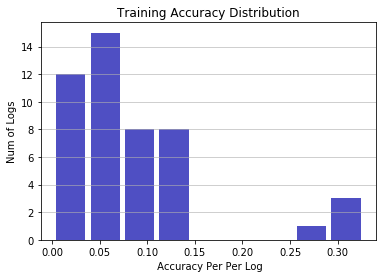

In [135]:
# plt.figure(figsize=(20, 20))
n, bins, patches = plt.hist(error, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Num of Logs')
plt.xlabel(' Accuracy Per Per Log')
plt.title('Training Accuracy Distribution')
# plt.text(30, 50, r'$\mu=10, b=5$')
max_freq = n.max()
# plt.ylim(top=np.ceil(max_freq / 10) * 10 if max_freq % 10 else max_freq + 10)
# plt.xlim(right=3)
# plt.show()
# plt.savefig(MAIN_dir+'\Signals\/validation_accuracy.png', dpi=1200)


In [74]:
np.save(MAIN_dir+'data_files/mass_vol_prd.npy',mass_prd)